Continuing the Star Wars example from last time. We want to infer the value of the surface gravity (standard gravity) of the Death Star. We have gathered experiment data for a projectile that was shot across the surface of the Death Star surface and the range was measured. This time we will use Bayesian MCMC to evaulate the mean and uncertainty in the value of 'g'. At the end, we will also examine how simulation systematic error can influence this type of analysis. May the force be with us. 


In [1]:
# Import useful python modules 
import numpy as np
import pandas as pd
from scipy import optimize, stats, integrate
from scipy.stats import norm
import emcee
import matplotlib.pyplot as plt
from MCUQ import * # This is a set of custom functions we will use
rng = np.random.RandomState(314) # use the same seed for reproducibility 

In [2]:
# read the Death Star projectile experiment data
df = pd.read_csv('range_data_exp.csv')

# Our measureables and associated error
alphaMeas = df['alpha'] # list of shot angles 
rObs = df['rObs'] # measured observables
rErr = df['rErr'] # measurement errors

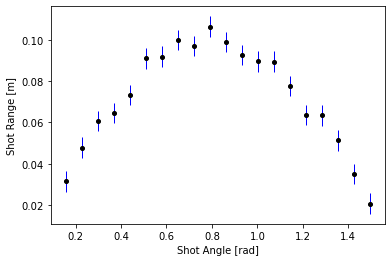

In [3]:
# plot the observable range data (and error) over all shot angles
plt.figure(1)
plt.errorbar(alphaMeas, rObs, yerr=rErr, lw=0, elinewidth=1, ecolor='b', fmt='ko', markersize=4)
plt.xlabel('Shot Angle [rad]')
plt.ylabel('Shot Range [m]');

In [4]:
#Emperical model for the projectile range
def modelFit(alpha, g):
    v0=1. # initial speed is always = 1 m/s
    r = (v0 ** 2) * np.sin(2.*alpha)/g
    return r

Optimal g = 9.77626[m/s^2]


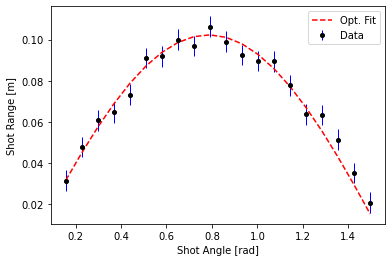

In [8]:
#Least squares fit of the data

g0 = 9.80665 # [m]/[s^2]: OG-g [Nominal value of standard gravity on Tatooine]
gOp, aCova = optimize.curve_fit(modelFit, alphaMeas, rObs, g0)

# plot the experiment data and the optimal fit curve
plt.figure(2)
plt.errorbar(alphaMeas, rObs, yerr=rErr, lw=0, elinewidth=1, ecolor='b', fmt='ko', markersize=4)
plt.plot(alphaMeas, modelFit(alphaMeas, *gOp),'--r')
plt.xlabel('Shot Angle [rad]')
plt.ylabel('Shot Range [m]')
plt.legend(['Opt. Fit','Data'])
print('Optimal g = {0:.5f}[m/s^2]'.format(gOp[0]));

Now we will use Bayesian Markov-Chain Monte Carlo (MCMC) to sample the distribution for 'g'. 
----------------------

1). We first define the likelihood of observing the data, given the value of 'g'. The probability is assumed to be normal and is a function of the difference between the observable data and the model -- evaluated at our guessed value for 'g'. 
                        
                        P(D|g) = normal distribution

2). Then we define the prior probability. This contains the information we already know about 'g'. We may only know a range that 'g' is allowed to be in or we may know a distribution that comes from another source. Each choice may alter the final posterior distribution for 'g'. 

                        P(g) = flat or normal : in this example. 

3). We take the new posterior computed from the prior and the likelihood, and compare that to the previous value of the likelihood. (This is the acceptance probability)

4). Then we perform the Metropolis-Hastings step. Comapring the acceptance value to a random number drawn from a uniform distribution.

5). IF the acceptance is greater than the random number, we accept that trial value of 'g', and keep the value for the likelihood for the next step. If it is less than 1, we only accept the value of 'g' if the random number is less than the acceptance probability.

In [9]:
# The likelihood function for computing the acceptance probability

def modelFit(alpha, g):
    v0=1. # initial speed is always = 1 m/s
    r = (v0 ** 2) * np.sin(2.*alpha)/g
    return r


def likelihood(rObs, rGuess, rErr):
    
    llh = np.sqrt(1/(2*np.pi*np.power(rErr,2)))*np.exp(-np.power(0.5*(rObs-rGuess)/rErr,2))
    
    return np.prod(llh)

def prior_flat(g_guess):
    
    if g_guess > 0.66*gOp[0] and g_guess < 1.33*gOp[0]:
        return 1.
    else:
        return 0.
def prior_norm(g_guess, g_mean, g_std):
    
    return norm.pdf(g_guess, g_mean, g_std)

In [10]:

gBounds = [0.66*gOp[0], 1.33*gOp[0]] # sampling bounds for 'g'
gGuess0 = gOp[0]#at the optimal vaule

rGuess0 = modelFit(alphaMeas,gGuess0)
llh0 = likelihood(rObs, rGuess0, rErr) # initialize MCMC 

prf0 = prior_flat(gGuess0)
postf0 = llh0 * prf0

burnIn = 1000 # Burn-in to get the sampler close to the 'True' value of 'g'
nTrials = 3000 # Number of total MCMC trials : [final sample size = nTrials - burnIn]

In [11]:
gAcceptMCMC_Flat = list() # A place to store our accepted values of 'g'

# The MCMC Metropolis-Hastings Loop using Bayes rule
n=0
while n < nTrials: # this will guarantee that we have the same sample size as the MC-Opt method
    
    gGuess_flat = rng.uniform(low=gBounds[0],high=gBounds[1]) # generate new 'g' guess - flat proposal
    rGuess = modelFit(alphaMeas,gGuess_flat) # evaluate range model
    
    llh = likelihood(rObs, rGuess, rErr) # compute the likelihood of observing the data given 'g' guess   
    prf = prior_flat(gGuess_flat)
    
    postf = llh * prf # "posterior"
    
    r = rng.uniform() # roll the dice    
    acceptProbf = postf/postf0 # compute acceptance probablity
    
    # Metropolis-Hastings check
    if r < acceptProbf: #(True->accept 'g' guess)
        gAcceptMCMC_Flat.append(gGuess_flat) # record 'g' guess
        postf0=postf
    else: # else do nothing and keep previous 'g'
        pass
    
    n = len(gAcceptMCMC_Flat)

gAcceptMCMC_Flat = np.asarray(gAcceptMCMC_Flat[burnIn:]) # only keep the samples after the burn-in

In [12]:
len(gAcceptMCMC_Flat)

2000

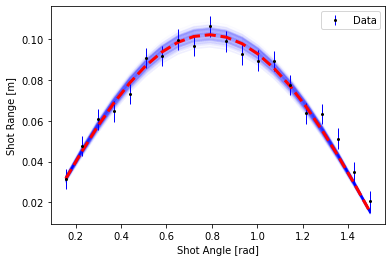

In [13]:
# Plot of the ensemble of optimal range curves over the data+error

plt.figure(4)
plt.errorbar(alphaMeas, rObs, yerr=rErr, lw=0, elinewidth=1, ecolor='b', fmt='ko', markersize=2)
plt.legend(['Data'])
for g in gAcceptMCMC_Flat[:200]:
    plt.plot(alphaMeas, modelFit(alphaMeas, g),'-b', alpha=0.02)

plt.plot(alphaMeas, modelFit(alphaMeas, *gOp),'r--', lw=3)
plt.xlabel('Shot Angle [rad]')
plt.ylabel('Shot Range [m]');

The mean value of the g ensemble using MCMC is: = 9.79346
The optimal g found with fitting was: = 9.77626
The % difference is : = 0.10323%


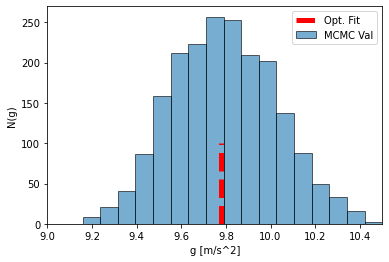

In [14]:
#%% Plot the histogram of accept 'g' values from the MCMC code
plt.figure(5)
plt.hist(gAcceptMCMC_Flat, bins=np.linspace(9.0,10.5,20), edgecolor='k', alpha=0.6)
plt.plot(gOp[0]*np.ones(10), np.linspace(0,100,10),'--r', lw=5);
plt.xlim([9.0,10.5])
plt.ylabel('N(g)')
plt.xlabel('g [m/s^2]')
plt.legend(['Opt. Fit','MCMC Val'])
print('The mean value of the g ensemble using MCMC is: = {0:.5f}'.format(np.mean(gAcceptMCMC_Flat)))
print('The optimal g found with fitting was: = {0:.5f}'.format(gOp[0]))
print('The % difference is : = {0:.5f}%'.format(np.abs(100*(1.-np.median(gAcceptMCMC_Flat)/gOp[0]))));


In [15]:
# Use the normal prior

g_mean = 1.*gOp[0]
g_std = 0.02*gOp[0]

gGuess0 = gOp[0]#at the optimal vaule

llh0 = likelihood(rObs, rGuess0, rErr) # initialize MCMC 
prn0 = prior_norm(gGuess0, g_mean, g_std)

rGuess0 = modelFit(alphaMeas, gGuess0)
postn0 = llh0 * prn0

burnIn = 1000 # Burn-in to get the sampler close to the 'True' value of 'g'
nTrials = 3000 # Number of total MCMC trials : [final sample size = nTrials - burnIn]

In [16]:
gAcceptMCMC_Norm = list() # A place to store our accepted values of 'g'

# The MCMC Metropolis-Hastings Loop using Bayes rule
n=0
while n < nTrials: # this will guarantee that we have the same sample size as the MC-Opt method
    
    gGuess_norm = rng.normal(loc=g_mean,scale=g_std) # generate new 'g' guess - normal proposal
    #gGuess_flat = rng.uniform(low=gBounds[0],high=gBounds[1]) # generate new 'g' guess - flat proposal
    rGuess = modelFit(alphaMeas,gGuess_flat) # evaluate range model
    
    llh = likelihood(rObs, rGuess, rErr) # compute the likelihood of observing the data given 'g' guess
    
    prn = prior_norm(gGuess_norm,g_mean,g_std)
    
    postn = llh * prn
    
    r = rng.uniform() # roll the dice
    
    acceptProbn = postn/postn0 # compute acceptance probablity
    
    # Metropolis-Hastings check
    if r < acceptProbn: #(True->accept 'g' guess)
        gAcceptMCMC_Norm.append(gGuess_norm) # record 'g' guess
        postn0=postn
    else: # else do nothing and keep previous 'g'
        pass
    
    n = len(gAcceptMCMC_Norm)

gAcceptMCMC_Norm = np.asarray(gAcceptMCMC_Norm[burnIn:]) # only keep the samples after the burn-in

In [17]:
len(gAcceptMCMC_Norm)

2000

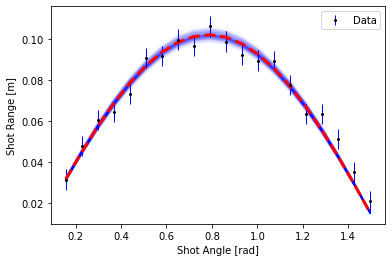

In [18]:
# Plot of the ensemble of optimal range curves over the data+error

plt.figure(4)
plt.errorbar(alphaMeas, rObs, yerr=rErr, lw=0, elinewidth=1, ecolor='b', fmt='ko', markersize=2)
plt.legend(['Data'])
for g in gAcceptMCMC_Norm[:200]:
    plt.plot(alphaMeas, modelFit(alphaMeas, g),'-b', alpha=0.02)

plt.plot(alphaMeas, modelFit(alphaMeas, *gOp),'r--', lw=3)
plt.xlabel('Shot Angle [rad]')
plt.ylabel('Shot Range [m]');

The mean value of the g ensemble using MCMC is: = 9.77811
The optimal g found with fitting was: = 9.77626
The % difference is : = 0.04014%
The uncertainty in g is : = 0.14755 and the std in g-prior is : = 0.19553%


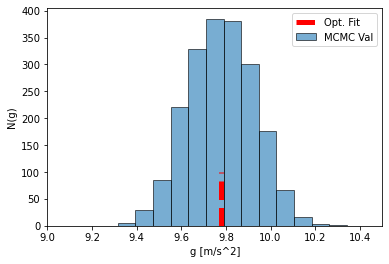

In [19]:
#%% Plot the histogram of accept 'g' values from the MCMC code
plt.figure(5)
plt.hist(gAcceptMCMC_Norm, bins=np.linspace(9.0,10.5,20), edgecolor='k', alpha=0.6)
plt.plot(gOp[0]*np.ones(10), np.linspace(0,100,10),'--r', lw=5);
plt.xlim([9.0,10.5])
plt.ylabel('N(g)')
plt.xlabel('g [m/s^2]')
plt.legend(['Opt. Fit','MCMC Val'])
print('The mean value of the g ensemble using MCMC is: = {0:.5f}'.format(np.mean(gAcceptMCMC_Norm)))
print('The optimal g found with fitting was: = {0:.5f}'.format(gOp[0]))
print('The % difference is : = {0:.5f}%'.format(np.abs(100*(1.-np.median(gAcceptMCMC_Norm)/gOp[0]))));
print('The uncertainty in g is : = {0:.5f} and the std in g-prior is : = {1:.5f}%'.format(np.std(gAcceptMCMC_Norm),g_std ));

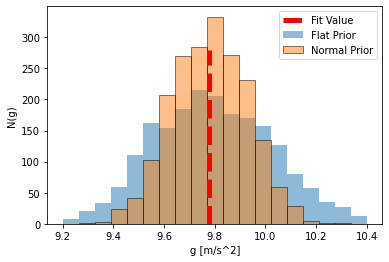

In [20]:
plt.figure('fig7')
plt.clf()

bins=np.linspace(9.2,10.4,20)

plt.plot(gOp[0]*np.ones(10), np.linspace(0,280,10),'--r', lw=5)
plt.hist(gAcceptMCMC_Flat, bins=bins, alpha=0.5)
plt.hist(gAcceptMCMC_Norm, bins=bins, edgecolor='k', alpha=0.5)
#plt.hist(samples_theory, bins=np.linspace(9.2,10.2,20), edgecolor='k', alpha=0.5)

plt.ylabel('N(g)')
plt.xlabel('g [m/s^2]')
plt.legend(['Fit Value','Flat Prior','Normal Prior']); #,'Bayes-Theory'
#plt.legend(['CG Simulation','Theory', 'Model'])

# What about numerical error (Simulation/Model error)?

So far we have considered using inverse forward error propagtion to find the expected value of 'g'. The mmoments of 'g' are intimately related to the error from our observations. However, this is only one type of error that can enter the analysis. There are two other types 1). model error -- having an incomplete model which we are using as our objective. 2) numerical error -- approximations that are used in simulation codes can also propagte error to our final ensemble for 'g'.

In the next example we will again look for the ensemble of 'g' but we will use a numerical simulation to directly simulate the entire trajectory of the laser canon shot. This entails integrating the equations of motion for a projectile. We will then compare this result with the exact theoretical equations for projectile motion x(t), y(t). 

What we will find is that for the simulation our estimate for 'g' and its uncertainty change depending on the accuracy of our numerical simulation. 

There is a good amount of code "under the hood" that won't be shown in the jupyter notebook, but you can find al the details of the simulation in the library called "MCUQ.py"


We will also use a "black box" Bayesian MCMC python library called Emcee -- The "MCMC" Hammer. 
You can find more about this code here: https://emcee.readthedocs.io/en/stable/

In [21]:
# The discrete numerical simulation for a 2d-projectile 
# time = the total simulation time (seconds)
# initial = the initial positions and speed [x0,y0,v0]
# g = standard gravity
# alpha = shot angle 
# ncg - number of integration steps: time_step = max(time)/ncg

def Sim(time, initial, g, alpha, ncg):
    
    if ncg < len(time):
        cgtime = np.linspace(time[0],time[len(time)-1],ncg)
    else:
        cgtime = time
        
    x0, y0, v0 = initial
    
    v0x = np.cos(alpha) * v0
    v0y = np.sin(alpha) * v0
    
    vx = v0x*np.ones(len(cgtime))
    vy = v0y - 1.0*g*cgtime
    
    x = integrate.cumtrapz(vx, cgtime)
    y = integrate.cumtrapz(vy, cgtime)
    
    y = np.insert(y,0,0.0)
    x = np.insert(x,0,0.0)
    
    return x,y, cgtime

In [22]:
time = np.linspace(0,1, 1000) # [s] flight time (just make this very big)
# initial conditions
x0 = 0.
y0 = 0.
v0 = 1.0
initial = [x0,y0,v0]

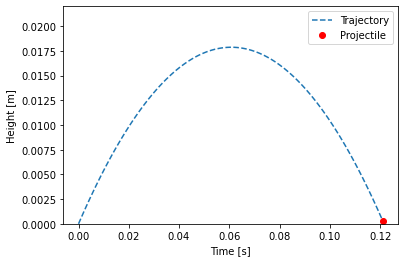

In [23]:
# A single projectile trajectory 
alpha = np.pi/5 # shot angle
ncg=len(time) # The total number of time steps (>=1). The bigger the number, the slower (longer) it will run (1000 works pretty good)

#See library MCUQ.py for details on below functions
x, y, cgtime = Sim(time, initial, g, alpha, ncg) # simulation code: 
tidx, idx, xdisp, ydisp = Range(x,y,cgtime) # A function that calculates projectile range from simulation data

plt.figure(5)
plt.plot(time[tidx], y[tidx],'--')
plt.plot(time[idx], ydisp, 'ro')
plt.ylim([0,0.022])
plt.xlabel('Time [s]')
plt.ylabel('Height [m]');
plt.legend(['Trajectory', 'Projectile']);

In [24]:
# Define functions for running emcee MCMC "The MCMC Hammer"

"""Here we define two more functions. The first 'gen_init', generates a random configuration of starting parameters 
for our Markov chain. In our problem we only have one, but there is one generated for each of the Markov Chains(MCs). 
Usually for simple problems like this one we just have a couple MCs ~2*number of model parameters (dimensions)"""

def gen_init(init, nd, nw):
    
    # we just want to start of near the initial position. 
    return [init + 1.e-6 * np.random.randn(nd) for i in range(nw)]

def compute_mcmc(degree, nburn, logposterior,  args): #,model, logposterior=logposterior, nburn
    
    ndim = degree + 1  # this determines the model dimension 0 -> 1 parameter
    nwalkers = 2*ndim # Number of MCs
    
    init = gen_init(gOp, ndim, nwalkers)
    # Call the Sampler class from emcee
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=args)
    # Run the burn-in 
    p0, _, _ = sampler.run_mcmc(init, nburn)
    sampler.reset() # Book keeping
    # Run the production run
    sampler.run_mcmc(p0, 4*nburn , progress = True)
    # Return the parameter ensemble
    return sampler.flatchain

In [31]:
# We run the coarse grain simulation through MCMC as the objective. 

ncg = 1500 # integration steps for the simulation (More steps = finer grain, less = course grain)
args = runSim, time, alphaMeas, initial, ncg, rObs, rErr
samples_sim = compute_mcmc(0, 500, simlogposterior, args) #(0 degree, 500 burn-in, posterior function, other)

100%|██████████| 2000/2000 [00:12<00:00, 159.20it/s]


In [26]:
# Run a separate MCMC using the exact theoretical prediction as the objective 

In [27]:
# We run the theory through MCMC as the objective. 
args = runTheory, time, alphaMeas, initial, rObs, rErr
samples_theory = compute_mcmc(0, 500, theorylogposterior, args) #(0 degree, 500 burn-in, posterior function, other)

100%|██████████| 2000/2000 [00:07<00:00, 278.73it/s]


The uncertainty in g is from Sim: = 0.130 [m/s^2] and the mean is : = 9.749 [m/s^2]
The uncertainty in g is from Theory: = 0.133 and the mean is : = 9.769


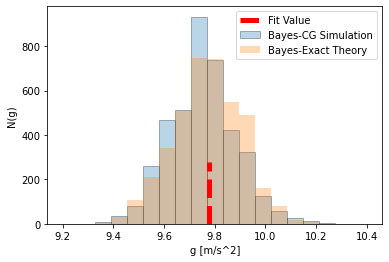

In [32]:
# compare the numerical simulation and the exact theory 
plt.figure('fig7')
plt.clf()

bins=np.linspace(9.2,10.4,20)

plt.plot(gOp[0]*np.ones(10), np.linspace(0,280,10),'--r', lw=5)
#plt.hist(gAccept, bins=bins, alpha=0.5)
plt.hist(samples_sim, bins=bins, edgecolor='k', alpha=0.3)
plt.hist(samples_theory, bins=bins, edgecolor='none', alpha=0.3)

plt.ylabel('N(g)')
plt.xlabel('g [m/s^2]')
plt.legend(['Fit Value','Bayes-CG Simulation','Bayes-Exact Theory']); #,'Bayes-Theory'
print('The uncertainty in g is from Sim: = {0:.3f} [m/s^2] and the mean is : = {1:.3f} [m/s^2]'.format(np.std(samples_sim), np.mean(samples_sim) ) );
print('The uncertainty in g is from Theory: = {0:.3f} and the mean is : = {1:.3f}'.format(np.std(samples_theory), np.mean(samples_theory)) );

In [29]:
# We run the coarse grain simulation through MCMC as the objective. 

ncg = 250 # integration steps for the simulation (More steps = finer grain, less = course grain)
args = runSim, time, alphaMeas, initial, ncg, rObs, rErr
samples_sim = compute_mcmc(0, 500, simlogposterior, args) #(0 degree, 500 burn-in, posterior function, other)

100%|██████████| 2000/2000 [00:15<00:00, 133.28it/s]


The uncertainty in g is from Sim: = 0.128 [m/s^2] and the mean is : = 9.605 [m/s^2]
The uncertainty in g is from Theory: = 0.133 and the mean is : = 9.769


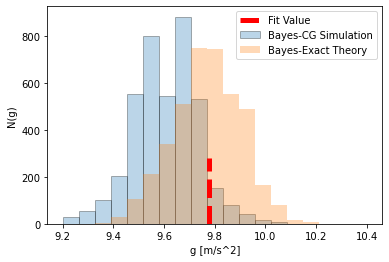

In [30]:
# compare the numerical simulation and the exact theory 
plt.figure('fig7')
plt.clf()

bins=np.linspace(9.2,10.4,20)

plt.plot(gOp[0]*np.ones(10), np.linspace(0,280,10),'--r', lw=5)
#plt.hist(gAccept, bins=bins, alpha=0.5)
plt.hist(samples_sim, bins=bins, edgecolor='k', alpha=0.3)
plt.hist(samples_theory, bins=bins, edgecolor='none', alpha=0.3)

plt.ylabel('N(g)')
plt.xlabel('g [m/s^2]')
plt.legend(['Fit Value','Bayes-CG Simulation','Bayes-Exact Theory']); #,'Bayes-Theory'
print('The uncertainty in g is from Sim: = {0:.3f} [m/s^2] and the mean is : = {1:.3f} [m/s^2]'.format(np.std(samples_sim), np.mean(samples_sim) ) );
print('The uncertainty in g is from Theory: = {0:.3f} and the mean is : = {1:.3f}'.format(np.std(samples_theory), np.mean(samples_theory)) );